<a href="https://colab.research.google.com/github/ReuelNixon/learn-pytorch/blob/main/02_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Classification Exercises

In [1]:
# Import torch
import torch
from torch import nn

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.03, random_state=42)

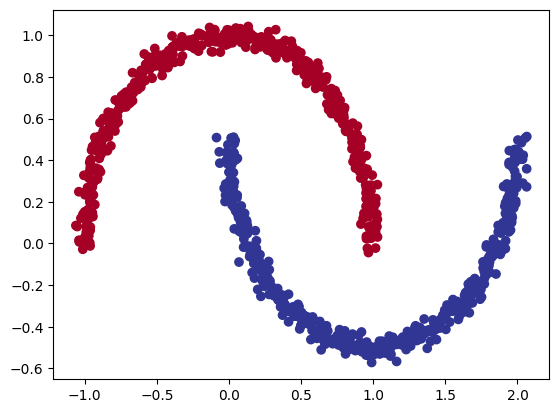

In [3]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [4]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train[:5], X_test[:5], y_train[:5], y_test[:5]

(tensor([[ 0.5754, -0.3962],
         [ 0.7647, -0.4829],
         [ 1.8676, -0.0060],
         [-0.0093,  0.3910],
         [ 1.8526, -0.0454]]),
 tensor([[-0.6096,  0.8319],
         [-0.8095,  0.5928],
         [ 0.0072,  0.3056],
         [ 0.4678,  0.9210],
         [-0.9204,  0.3621]]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([0., 0., 1., 0., 0.]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [5]:
# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, intermediate_features):
      super().__init__()

      self.layer_stack = nn.Sequential(
          nn.Linear(in_features, out_features=intermediate_features),
          nn.ReLU(),
          nn.Linear(intermediate_features, out_features=intermediate_features),
          nn.ReLU(),
          nn.Linear(intermediate_features, out_features=out_features)
      )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0(2, 1, 8).to(device)
model_0

MoonModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [6]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [7]:
# What's coming out of our model?
# logits (raw outputs of model)
print("Logits:")
logits = model_0(X_train[:5])
print(logits)

# Prediction probabilities
print("Pred probs:")
pred_probs = torch.sigmoid(logits).squeeze()
print(pred_probs)

# Prediction labels
print("Pred labels:")
pred_labels = torch.round(pred_probs)
print(pred_labels)

Logits:
tensor([[0.0233],
        [0.0213],
        [0.0273],
        [0.0261],
        [0.0269]], grad_fn=<AddmmBackward0>)
Pred probs:
tensor([0.5058, 0.5053, 0.5068, 0.5065, 0.5067], grad_fn=<SqueezeBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [8]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [9]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 2000

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  train_logits = model_0(X_train).squeeze()
  # Turn logits into prediction probabilities
  train_preds = torch.round(torch.sigmoid(train_logits))

  # 2. Calculaute the loss
  loss = loss_fn(train_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(train_preds, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test) # loss = compare model raw outputs to desired model outputs
    test_acc = acc_fn(test_preds, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} \t Train Loss: {loss:.5f} \t Train Accuracy: {(acc*100):.2f}% \t Test Loss: {test_loss:5f} \t Test accuracy: {(test_acc*100):.2f}%')

Epoch: 0 	 Train Loss: 0.69400 	 Train Accuracy: 50.13% 	 Test Loss: 0.693924 	 Test accuracy: 49.50%
Epoch: 100 	 Train Loss: 0.65059 	 Train Accuracy: 70.25% 	 Test Loss: 0.657938 	 Test accuracy: 65.00%
Epoch: 200 	 Train Loss: 0.44310 	 Train Accuracy: 79.38% 	 Test Loss: 0.482015 	 Test accuracy: 75.00%
Epoch: 300 	 Train Loss: 0.30953 	 Train Accuracy: 87.38% 	 Test Loss: 0.338031 	 Test accuracy: 86.00%
Epoch: 400 	 Train Loss: 0.25902 	 Train Accuracy: 89.62% 	 Test Loss: 0.276270 	 Test accuracy: 88.00%
Epoch: 500 	 Train Loss: 0.23856 	 Train Accuracy: 89.62% 	 Test Loss: 0.252508 	 Test accuracy: 88.50%
Epoch: 600 	 Train Loss: 0.22686 	 Train Accuracy: 89.62% 	 Test Loss: 0.239145 	 Test accuracy: 89.00%
Epoch: 700 	 Train Loss: 0.21871 	 Train Accuracy: 89.12% 	 Test Loss: 0.229319 	 Test accuracy: 89.50%
Epoch: 800 	 Train Loss: 0.21312 	 Train Accuracy: 89.25% 	 Test Loss: 0.222643 	 Test accuracy: 89.50%
Epoch: 900 	 Train Loss: 0.20934 	 Train Accuracy: 89.12% 	 Test L

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [10]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

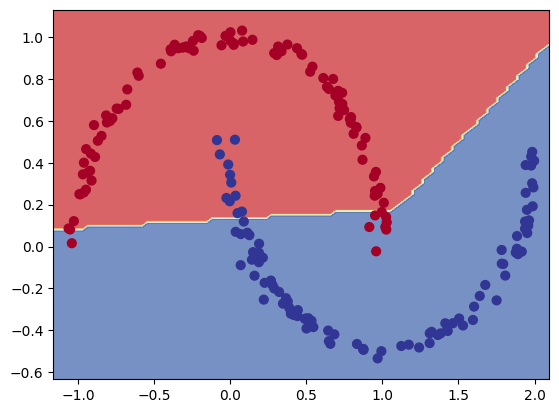

In [11]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

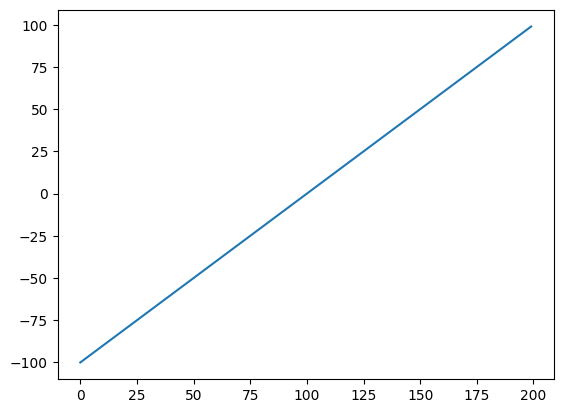

In [12]:
# Create a straight line tensor
x = torch.arange(-100, 100, 1)
plt.plot(x);

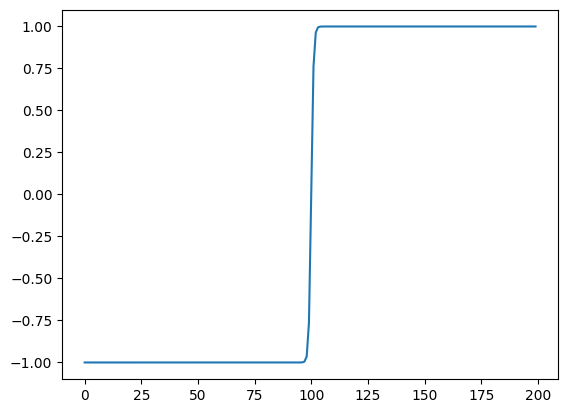

In [13]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(x));

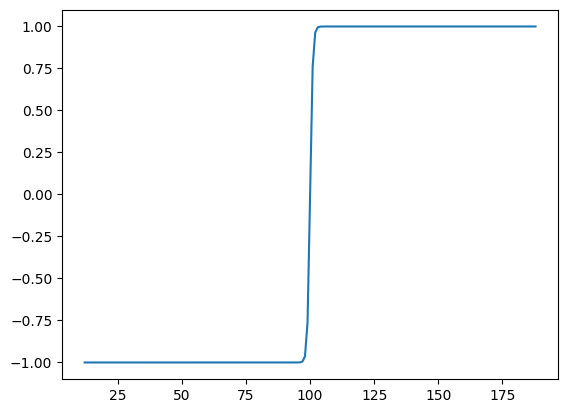

In [14]:
# Replicate torch.tanh() and plot it
def tanh(x):
  return(torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))
plt.plot(tanh(x));

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

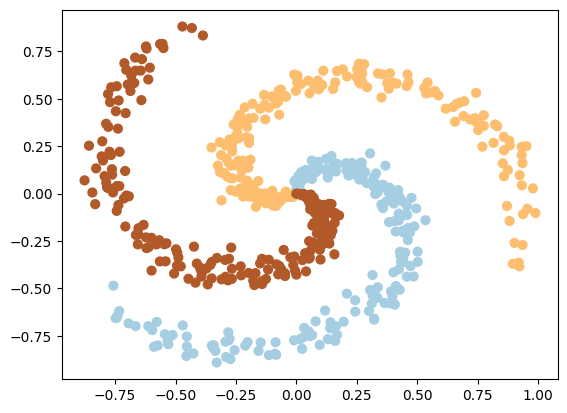

In [15]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Paired)
plt.show()

In [16]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train[:5], X_test[:5], y_train[:5], y_test[:5]

(tensor([[ 0.3919, -0.0060],
         [ 0.8546,  0.1597],
         [ 0.1053, -0.2281],
         [ 0.7527,  0.3356],
         [ 0.5883,  0.5181]]),
 tensor([[ 0.1609, -0.1029],
         [-0.7782,  0.3524],
         [-0.8285,  0.1334],
         [-0.6114, -0.2822],
         [ 0.0644,  0.0772]]),
 tensor([0, 1, 2, 1, 1]),
 tensor([2, 2, 2, 2, 0]))

In [17]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [18]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModelV0(nn.Module):
  def __init__(self, in_features, out_features, intermediate_features):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=out_features),
    )

  def forward(self, x):
    return self.layer_stack(x)


# Instantiate model and send it to device
model_1 = SpiralModelV0(2, 3, 8).to(device)
model_1

SpiralModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [19]:
# Setup data to be device agnostic
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
logits = model_1(X_train[:5])
print(logits)

print("Pred probs:")
pred_probs = torch.softmax(logits, dim = 1)
print(pred_probs)

print("Pred labels:")
pred_lables = pred_probs.argmax(dim = 1)
print(pred_labels)

Logits:
tensor([[-0.1256, -0.3571, -0.3091],
        [-0.2071, -0.3700, -0.4328],
        [-0.0740, -0.3591, -0.2361],
        [-0.1995, -0.3777, -0.4278],
        [-0.1726, -0.3993, -0.3990]], grad_fn=<AddmmBackward0>)
Pred probs:
tensor([[0.3809, 0.3022, 0.3170],
        [0.3777, 0.3209, 0.3014],
        [0.3843, 0.2890, 0.3268],
        [0.3798, 0.3178, 0.3023],
        [0.3854, 0.3072, 0.3073]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1.], grad_fn=<RoundBackward0>)


In [20]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [21]:
# Build a training loop for the model

epochs = 4000
# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. Forward pass
  train_logits = model_1(X_train)
  train_preds = torch.softmax(train_logits, dim = 1).argmax(dim = 1)

  # 2. Calculate the loss
  loss = loss_fn(train_logits, y_train)
  acc = acc_fn(train_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_preds, y_test)
  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} \t Train Loss: {loss:.5f} \t Train Accuracy: {(acc*100):.2f}% \t Test Loss: {test_loss:5f} \t Test accuracy: {(test_acc*100):.2f}%')


Epoch: 0 	 Train Loss: 1.09911 	 Train Accuracy: 34.58% 	 Test Loss: 1.104164 	 Test accuracy: 28.33%
Epoch: 100 	 Train Loss: 0.97830 	 Train Accuracy: 48.12% 	 Test Loss: 1.016937 	 Test accuracy: 35.83%
Epoch: 200 	 Train Loss: 0.82842 	 Train Accuracy: 57.71% 	 Test Loss: 0.901560 	 Test accuracy: 47.50%
Epoch: 300 	 Train Loss: 0.72260 	 Train Accuracy: 58.54% 	 Test Loss: 0.796976 	 Test accuracy: 50.00%
Epoch: 400 	 Train Loss: 0.66192 	 Train Accuracy: 58.75% 	 Test Loss: 0.725484 	 Test accuracy: 55.00%
Epoch: 500 	 Train Loss: 0.61423 	 Train Accuracy: 61.04% 	 Test Loss: 0.674846 	 Test accuracy: 56.67%
Epoch: 600 	 Train Loss: 0.56526 	 Train Accuracy: 66.25% 	 Test Loss: 0.627145 	 Test accuracy: 62.50%
Epoch: 700 	 Train Loss: 0.51726 	 Train Accuracy: 70.42% 	 Test Loss: 0.580461 	 Test accuracy: 66.67%
Epoch: 800 	 Train Loss: 0.47192 	 Train Accuracy: 73.96% 	 Test Loss: 0.534264 	 Test accuracy: 71.67%
Epoch: 900 	 Train Loss: 0.42925 	 Train Accuracy: 78.33% 	 Test L

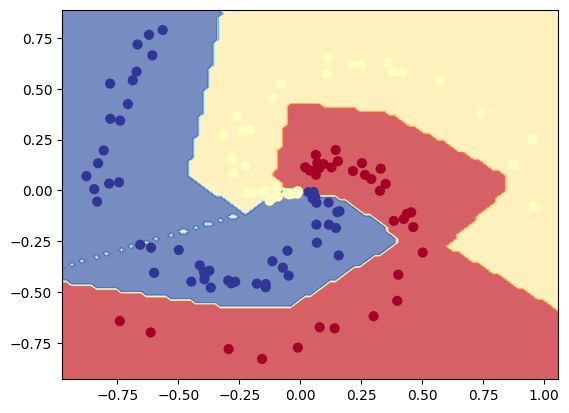

In [22]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_1, X_test, y_test)